## Library

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import yfinance as yf
import tensorflow as tf
from datetime import date
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Load Data

In [60]:
# params
ticker = 'BTC-USD'
start = '2012-01-01'
today = date.today().strftime('%Y-%m-%d')
look_back = 100
epochs = 100
batch_size = 64

In [54]:
data = yf.download(ticker, start, today)
data

C:\Users\jorda\AppData\Local\Temp\ipykernel_25164\2365557616.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, today)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100
...,...,...,...,...,...
2025-06-11,108686.625000,110384.218750,108086.328125,110261.796875,50842662052
2025-06-12,105929.054688,108780.695312,105785.687500,108685.914062,54843867968


## EDA

In [62]:
print(f'Duplicates: {data.duplicated().sum()}')
print(f'Shape: {data.shape}')
data.isna().sum()

Duplicates: 0
Shape: (3925, 5)


Price   Ticker 
Close   BTC-USD    0
High    BTC-USD    0
Low     BTC-USD    0
Open    BTC-USD    0
Volume  BTC-USD    0
dtype: int64

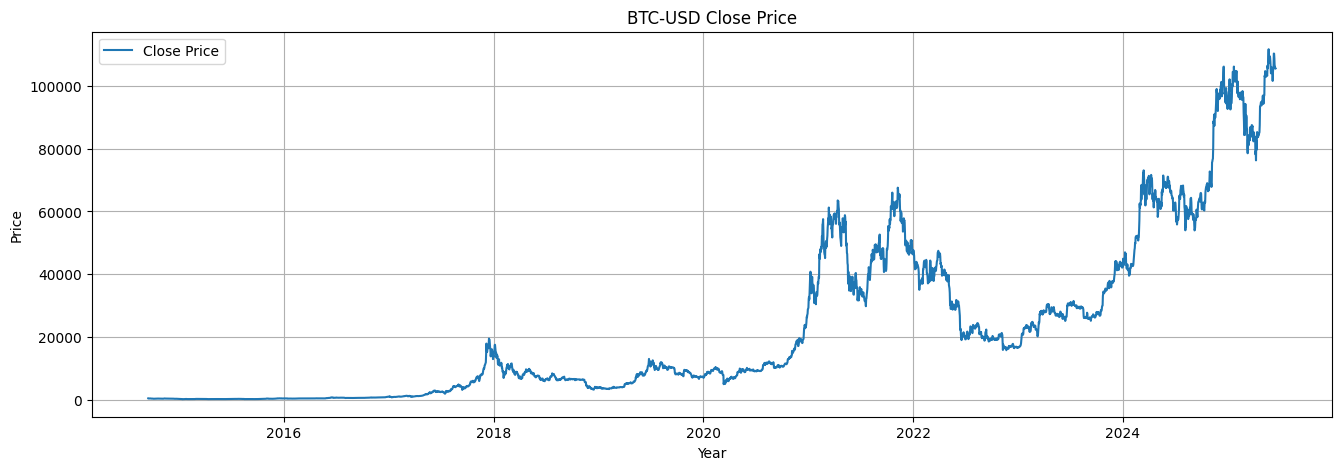

In [81]:
# close price chart
plt.figure(figsize=(16, 5))
plt.plot(data['Close'], label='Close Price')
plt.title(f'{ticker} Close Price')
plt.ylabel("Price")
plt.xlabel("Year")
plt.grid(True)
plt.legend()
plt.show()

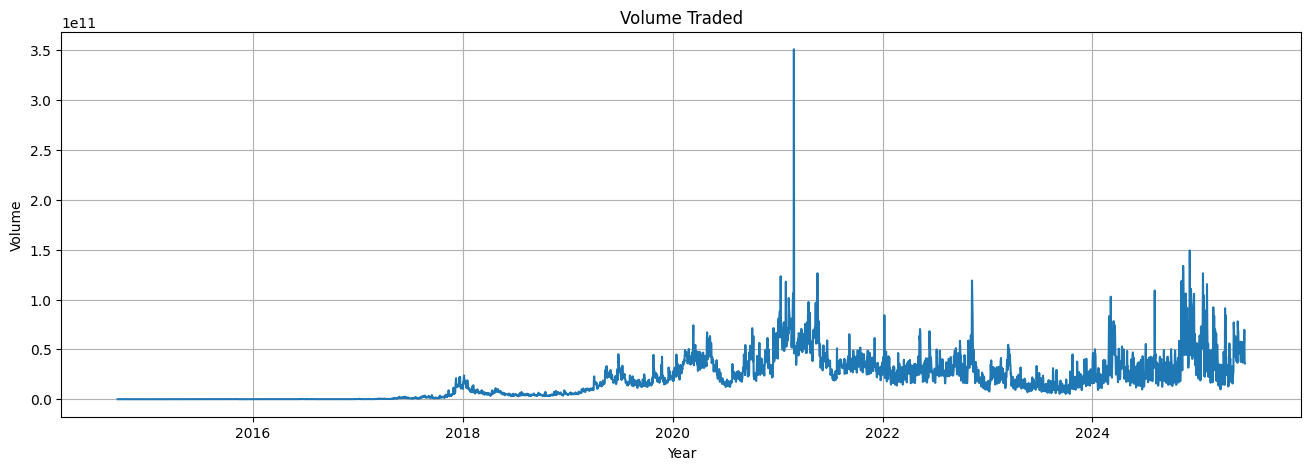

In [82]:
# volume chart
plt.figure(figsize=(16, 5))
plt.plot(data['Volume'], label='Volume Traded')
plt.title('Volume Traded')
plt.ylabel("Volume")
plt.xlabel("Year")
plt.grid(True)
plt.show()

<Axes: xlabel='Price-Ticker', ylabel='Price-Ticker'>

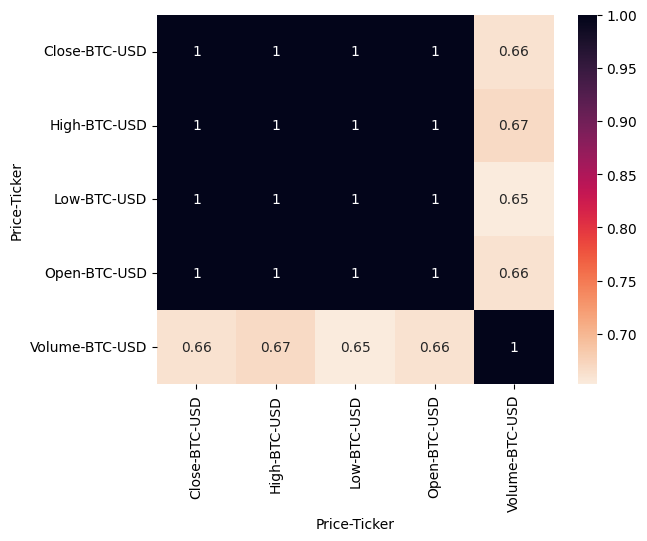

In [70]:
# features correlation
sns.heatmap(data.corr(), annot=True, cmap='rocket_r')

In [71]:
df = data[['Close']]

## Preprocess

In [98]:
# split
train_size = int(len(df) * 0.90)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (3532, 1)
Test shape: (393, 1)


In [99]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['Close']])

In [100]:
x_train = []
y_train = []

for i in range(look_back, train_scaled.shape[0]):
    x_train.append(train_scaled[i-look_back:i, 0])
    y_train.append(train_scaled[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [101]:
def build_model():
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=(look_back, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = build_model()
model.summary()

c:\Github Projects\stock-forecasting\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 100, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

In [102]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

In [103]:
history = model.fit(x_train, y_train, validation_split=0.1, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping, reduce_lr], verbose=1)

Epoch 1/100


49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0142 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0012 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0011 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0011 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 9.8639e-04 - val_loss: 9.6321e-04 - learning_rate: 0.0010
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 9.8010e-04 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 9.3181e-04 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0010 - val_loss: 8.4501e-04 - learning_rate: 0.0010
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 8.8516e-04 - val_loss: 0.0013 - learning_rate: 0.001

In [104]:
past_days = df.iloc[train_size - look_back:train_size] if train_size > look_back else df.iloc[0:train_size]
final_df = pd.concat([past_days, test], ignore_index=True)
test_scaled = scaler.transform(final_df[['Close']])

In [105]:
x_test = []
y_test = []

for i in range(look_back, test_scaled.shape[0]):
    x_test.append(test_scaled[i-look_back:i, 0])
    y_test.append(test_scaled[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [106]:
y_pred = model.predict(x_test)
y_test = y_test.reshape(-1,1)
y_test_rescaled = scaler.inverse_transform(y_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [107]:
# Errors

mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print("MSE:", mse)
print("MAE:", mae)
print("RMSE:", rmse)
print("R² Score:", r2)

MSE: 12199055.246423462
MAE: 2704.9649530852416
RMSE: 3492.7145956152017
R² Score: 0.9583759318713151


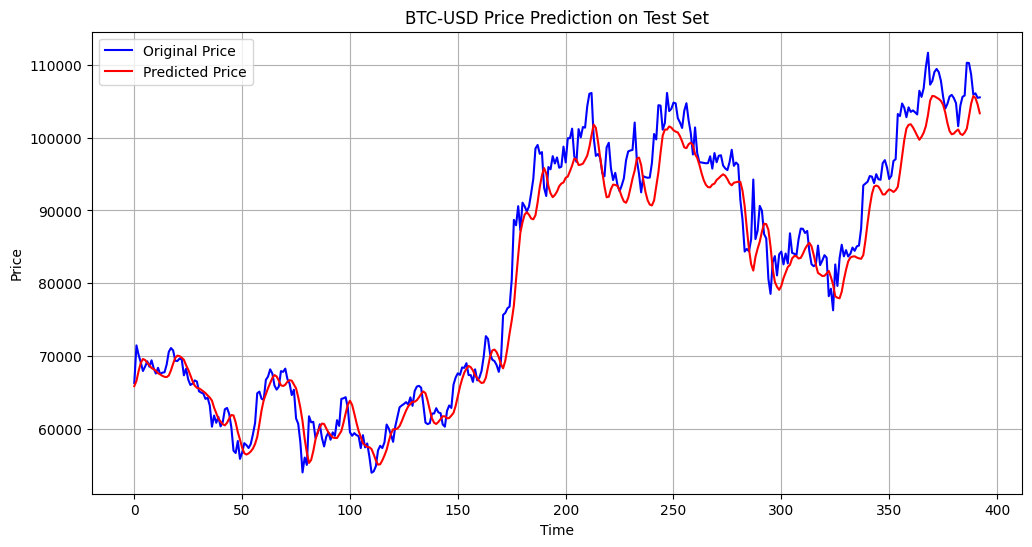

In [108]:
plt.figure(figsize=(12,6))
plt.plot(y_test_rescaled, 'b', label="Original Price")
plt.plot(y_pred_rescaled, 'r', label="Predicted Price")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.title(f'{ticker} Price Prediction on Test Set')
plt.show()

In [ ]:
last_100_days = df[-look_back:]['Close'].values.reshape(-1,1)
last_100_days_scaled = scaler.transform(last_100_days)

X_future = []
X_future.append(last_100_days_scaled)
X_future = np.array(X_future)
X_future = np.reshape(X_future, (X_future.shape[0], X_future.shape[1], 1))

next_day_pred = model.predict(X_future)
next_day_pred_rescaled = scaler.inverse_transform(next_day_pred)

print(f"Forecasted Close Price for the next day: {next_day_pred_rescaled[0,0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Forecasted Close Price for the next day: 102233.40


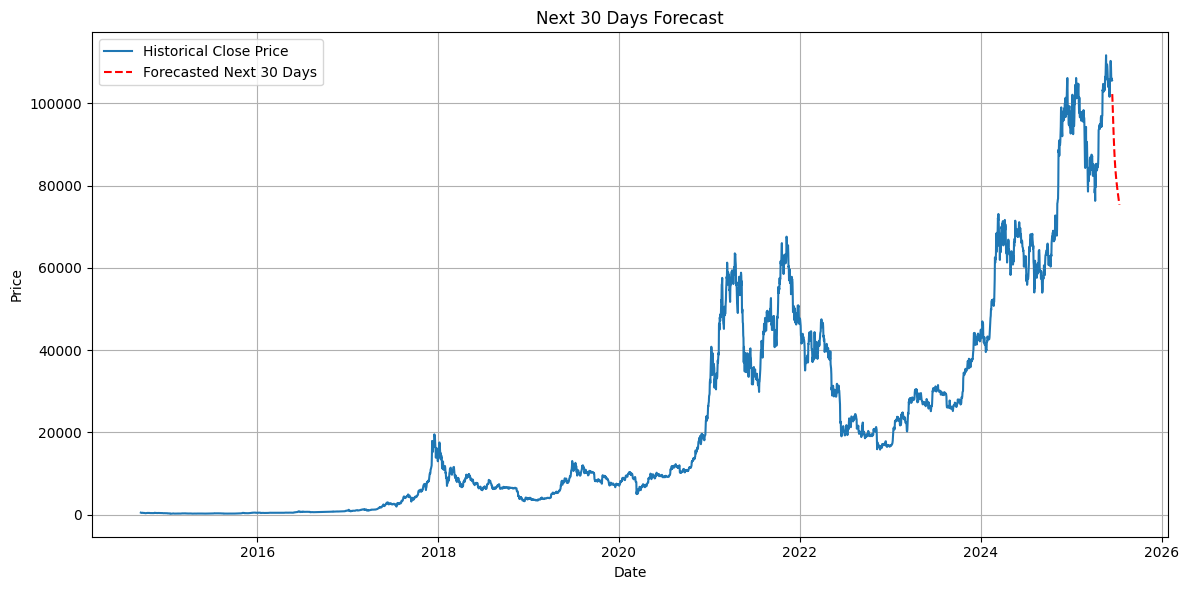

In [111]:
last_sequence = df[['Close']].values[-look_back:]
last_sequence_scaled = scaler.transform(last_sequence)

future_predictions = []

current_input = last_sequence_scaled.copy()

for _ in range(30):
    input_reshaped = np.reshape(current_input, (1, look_back, 1))
    next_pred = model.predict(input_reshaped, verbose=0)
    future_predictions.append(next_pred[0, 0])
    current_input = np.append(current_input[1:], [[next_pred[0, 0]]], axis=0)

future_predictions_rescaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='Historical Close Price')
future_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30)
plt.plot(future_index, future_predictions_rescaled, 'r--', label='Forecasted Next 30 Days')
plt.title('Next 30 Days Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()